# Predictive Modeling of Customer Bookings

This notebook delves into the complexities of predicting customer booking behaviors for British Airways using advanced data analytics. It begins with a detailed exploration and preparation of the dataset, followed by training a RandomForest machine learning model. This approach not only forecasts customer bookings but also reveals key factors influencing these behaviors. The report culminates in a thorough evaluation of the model's performance, providing valuable insights through visualizations and a summary slide designed for strategic decision-making within the airline.


## Data Preparation and Quality Assessment

This section focuses on the initial stages of our analysis, where we prepare and assess the quality of the British Airways customer booking dataset. The process begins with importing necessary Python libraries and loading the dataset using pandas. We conduct a preliminary review of the data to understand its structure and identify any immediate data quality issues.



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The data description, tells us that we don't have null values. To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

In [4]:
# Add new columns for departure and arrival city
df['departure_city'] = df['route'].apply(lambda x: x[:3])
df['arrival_city'] = df['route'].apply(lambda x: x[3:])

In [5]:
# Convert binary variables to categorical for summary
binary_columns = ['wants_extra_baggage', 'wants_preferred_seat', 'flight_day', 'wants_in_flight_meals', 
                  'booking_complete']
for col in binary_columns:
    df[col] = df[col].astype('category')
df.describe(include='category')

,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,booking_complete
count,50000,50000,50000,50000,50000
unique,7,2,2,2,2
top,Mon,1,0,0,0
freq,8102,33439,35152,28643,42522


In [6]:
df.describe(include = 'number')

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,7.277561
std,1.020165,90.451378,33.88767,5.41266,1.496863
min,1.000000,0.000000,0.00000,0.00000,4.670000
25%,1.000000,21.000000,5.00000,5.00000,5.620000
50%,1.000000,51.000000,17.00000,9.00000,7.570000
75%,2.000000,115.000000,28.00000,13.00000,8.830000
max,9.000000,867.000000,778.00000,23.00000,9.500000


In [7]:
df[['sales_channel', 'trip_type', 'booking_origin', 'departure_city', 
    'arrival_city']].describe()

,sales_channel,trip_type,booking_origin,departure_city,arrival_city
count,50000,50000,50000,50000,50000
unique,2,3,104,85,64
top,Internet,RoundTrip,Australia,DMK,SYD
freq,44382,49497,17872,3747,6616


According to the summary, there are **49,497** round trips (`trip_type` column) i.e., approx. **99%** of the data is for round trip. In such cases, the trip_type feature might not contribute significantly to the predictive power of a machine learning model due to its lack of variability. The majority class (**RoundTrip**) dominates the dataset, providing little to no unique information that can be used for classification or prediction tasks. **Therefore, `trip_type` column can be removed from the dataset for training the model.**

<!-- We'll convert `purchase_lead` to categories and define the bins for purchase_lead as follows:
- 0-30 days as short
- 31-180 days as medium
- 181-365 days as long
- more than 365 days as very long lead time -->

In [8]:
# bins = [0, 30, 180, 365, float('inf')]
# labels = ['Short', 'Medium', 'Long', 'Very Long']
# df['purchase_lead_category'] = pd.cut(df['purchase_lead'], bins=bins, labels=labels)


We'll transform `flight_hour` into time of day categories:

In [9]:
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['time_of_day'] = pd.cut(df['flight_hour'], bins=bins, labels=labels, right=False)


In [10]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,departure_city,arrival_city,time_of_day
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0,AKL,DEL,Morning
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0,AKL,DEL,Night
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0,AKL,DEL,Afternoon
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0,AKL,DEL,Night
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0,AKL,DEL,Afternoon



## Exploratory Data Analysis

This section provides a comprehensive overview of key variables influencing booking behaviors. Through visualizations like pie charts, count plots, and bar charts, we uncover trends in booking completions, passenger counts, time-of-day preferences, and sales channels. This analysis is crucial in identifying significant factors for the subsequent predictive modeling.

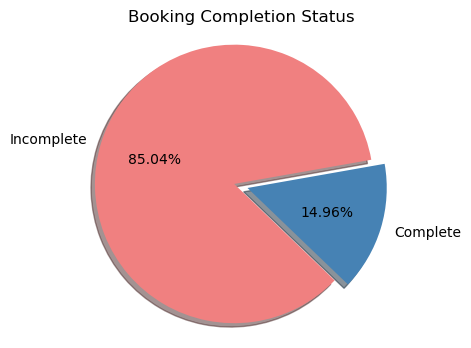

In [11]:
# Count the number of completed and not completed bookings
booking_counts = df['booking_complete'].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
explode = (0.1, 0) 
colors = ['lightcoral','steelblue']  

plt.pie(booking_counts, labels=['Incomplete', 'Complete'], 
        autopct='%1.2f%%', startangle=10, explode=explode, 
        shadow=True, colors=colors)

plt.title('Booking Completion Status')
plt.axis('equal')  
plt.show()


The observation that only **15%** of the customers have completed bookings indicates a significant class imbalance in the dataset. This imbalance must be carefully considered when splitting the data into training and test sets for predictive modeling, as it could heavily influence the model's accuracy.

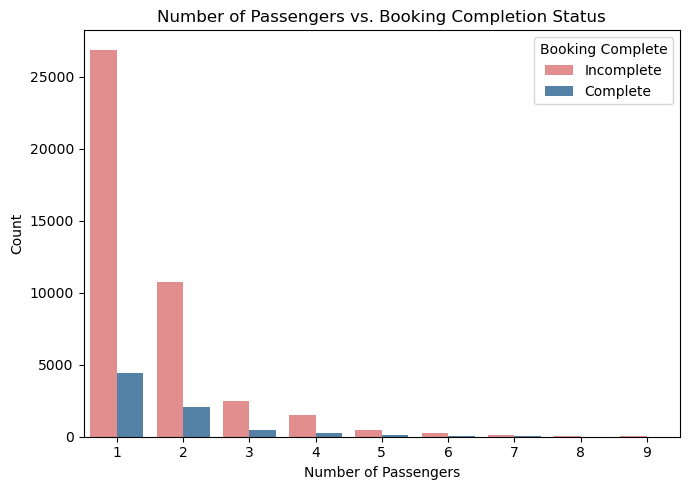

In [12]:
# Plot the number of passengers with booking completion status
plt.figure(figsize=(7, 5))
sns.countplot(x='num_passengers', hue='booking_complete', palette = colors, data=df)
plt.title('Number of Passengers vs. Booking Completion Status')
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.legend(title='Booking Complete', labels=['Incomplete', 'Complete'])
plt.tight_layout()
plt.show()

Based on the plot, the *Number of Passengers* variable shows a clear distinction in booking completion status. There is a larger count of bookings with just one passenger, and only a small portion of these bookings are completed. As the number of passengers increases, the number of bookings generally decreases, but the proportion of completed bookings also seems to decline.

This pattern suggests that *Number of Passengers* could be a significant variable for modeling, as it seems to be correlated with the likelihood of booking completion. Solo travelers or bookings for one passenger have a higher rate of completion, while bookings for larger groups are less common and have a lower completion rate.

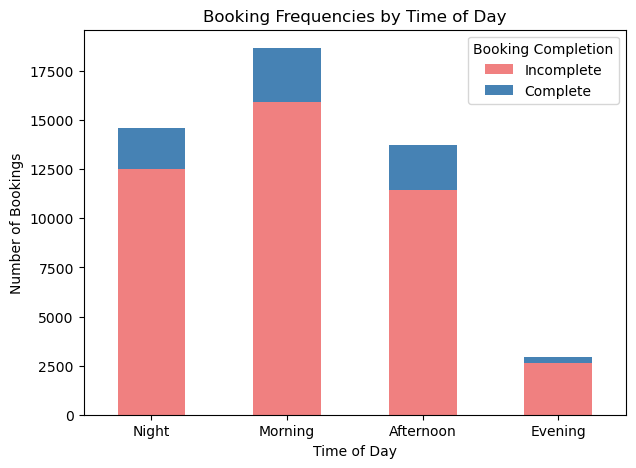

In [13]:
# Count the bookings for each time period in a day
time_of_day_counts = df.groupby(['time_of_day', 'booking_complete']).size().unstack(fill_value=0)

# Plot stacked bar chart 
time_of_day_counts.plot(kind='bar', stacked=True, figsize=(7, 5), color = colors)

plt.title('Booking Frequencies by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Bookings')
plt.legend(title='Booking Completion', labels=['Incomplete', 'Complete'])
plt.xticks(rotation=0)
plt.show()

This plot indicates that most bookings, both complete and incomplete, occur during the morning, followed by the afternoon, and the least number occur at night. The evening shows the lowest overall number of bookings, but the proportion of completed bookings during this time is relatively high compared to the total. This suggests that while fewer people book in the evening, those who do are more likely to complete their booking.

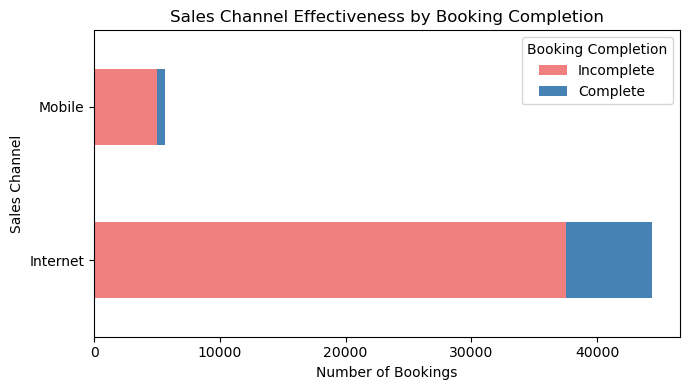

In [14]:
channel_booking_counts = df.groupby(['sales_channel', 'booking_complete']).size().unstack(fill_value=0)

# Plot horizontal stacked bar chart
channel_booking_counts.plot(kind='barh', stacked=True, figsize=(7, 4), color=colors)
plt.title('Sales Channel Effectiveness by Booking Completion')
plt.xlabel('Number of Bookings')
plt.ylabel('Sales Channel')
plt.legend(title='Booking Completion', labels=['Incomplete', 'Complete'])
plt.tight_layout()
plt.show()

In [15]:
# Calculate the percentage of each booking completion status for each sales channel
channel_booking_counts.div(channel_booking_counts.sum(axis=1), axis=0) * 100

booking_complete,0,1
sales_channel,,
Internet,84.523005,15.476995
Mobile,89.159843,10.840157


It is clear from the plot that the *Internet* sales channel has a significantly higher number of bookings compared to *Mobile*. Within the Internet channel, there is a notable portion of incomplete bookings, but the number of completed bookings is substantial. Similarly for the Mobile channel. 

- For the "Internet" channel, approximately **15.47%** of bookings are completed.
- For the "Mobile" channel, approximately **10.84%** of bookings are completed.

Given these observations, it is plausible that the `sales_channel` variable may have a significant impact on booking completion. To confirm this, we will conduct statistical testing to assess whether there is a statistically significant difference in booking completion rates between these two sales channels.

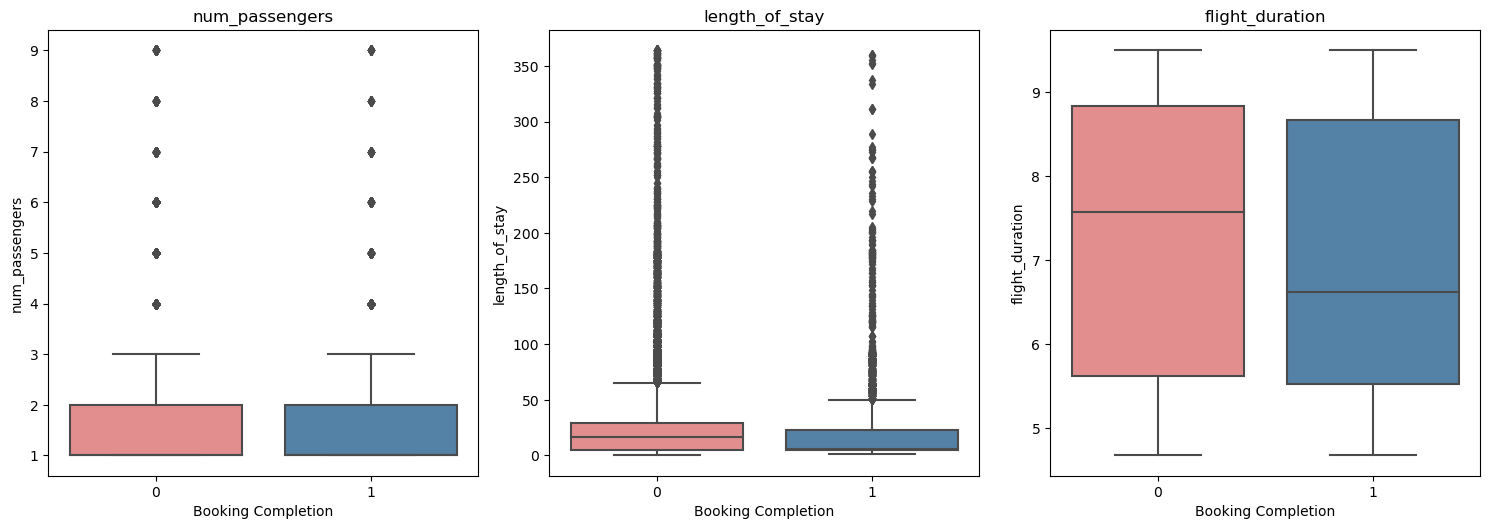

In [137]:
# Boxplots for Numerical Variables split by booking completion
numerical_columns = ['num_passengers', 'length_of_stay', 'flight_duration']
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='booking_complete', y=col, data=df, palette=colors)
    plt.title(f'{col}')
    plt.xlabel('Booking Completion')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In the airline industry, it's common to allow round trip bookings up to one year in advance. However, in our dataset's `length_of_stay` column, there are entries indicating stays close to **800** days, which is significantly longer than the standard one-year timeframe. We will specifically investigate instances where the `length_of_stay` exceeds one year to better understand these anomalies and determine their relevance to our analysis. 

In [17]:
len(df[df['length_of_stay']>365])

23

In our dataset, we found **23** rows where the `length_of_stay` is much higher than normal. Since these cases are rare and can distort our analysis, it makes sense to leave them out. This way, our results will more accurately reflect the common trends in the data without being skewed by a few unusual cases.

In [18]:
df = df[df['length_of_stay']<365]

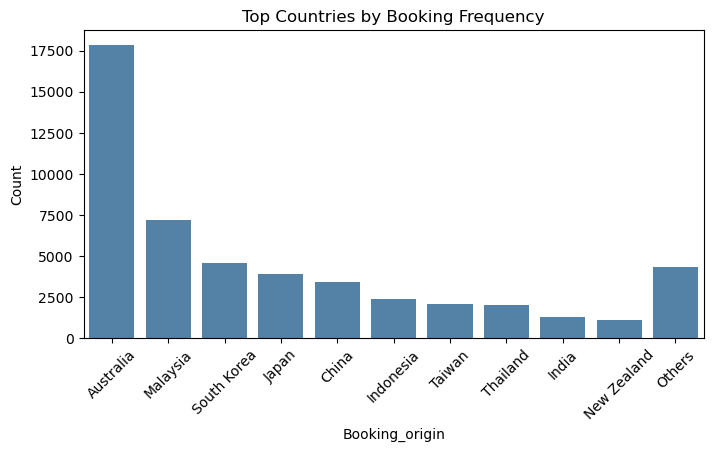

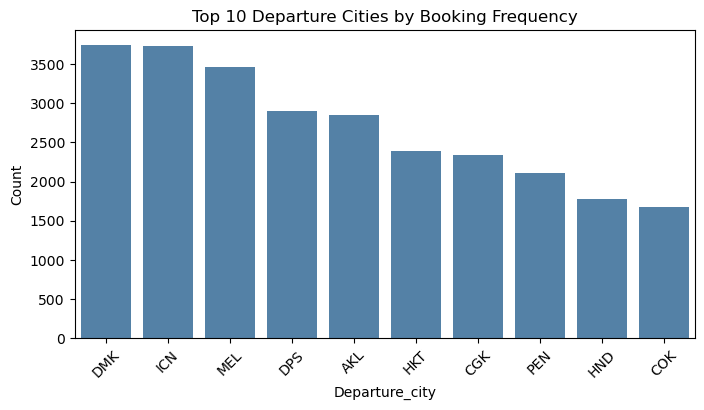

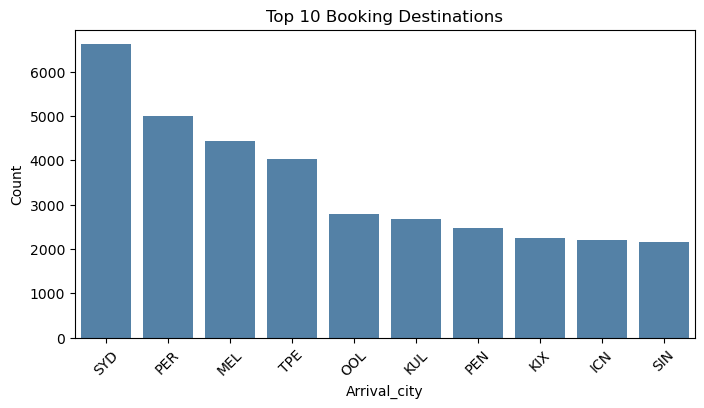

In [124]:
def plot_top_categories(df, column_name, include_others=True, title=''):
    # Count the occurrences of each category
    counts = df[column_name].value_counts()

    # Take top 10 categories
    top_categories = counts[:10].index.tolist()
    top_counts = counts[:10].values

    if include_others:
        # Calculate the 'Others' count by subtracting the sum of the top categories from the total
        others_count = [counts.sum() - top_counts.sum()]
        # Append 'Others' to the list of top categories
        top_categories.append('Others')
        # Append the 'Others' count to the list of top counts
        top_counts = np.append(top_counts, others_count)

    # Create a bar plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_categories, y=top_counts, color='steelblue')
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel(column_name.capitalize())
    plt.xticks(rotation=45)
    plt.show()

# Use the function to create plots for 'booking_origin', 'departure_city', and 'arrival_city'
plot_top_categories(df, 'booking_origin', title='Top Countries by Booking Frequency')
plot_top_categories(df, 'departure_city', include_others=False, title='Top 10 Departure Cities by Booking Frequency')
plot_top_categories(df, 'arrival_city', include_others=False, title='Top 10 Booking Destinations')

The visualizations show the volume and completion status of bookings across various countries of booking origin,  departure and arrival cities. The data shows that certain locations, like **DMK (Bangkok)** for departures and **Australia** for booking origins, have high traffic but a disproportionately low rate of completed bookings. As we prepare to train a predictive model, these three columns can be crucial. Given their categorical nature, we should encode them properly—likely using one-hot encoding for the model to interpret. 

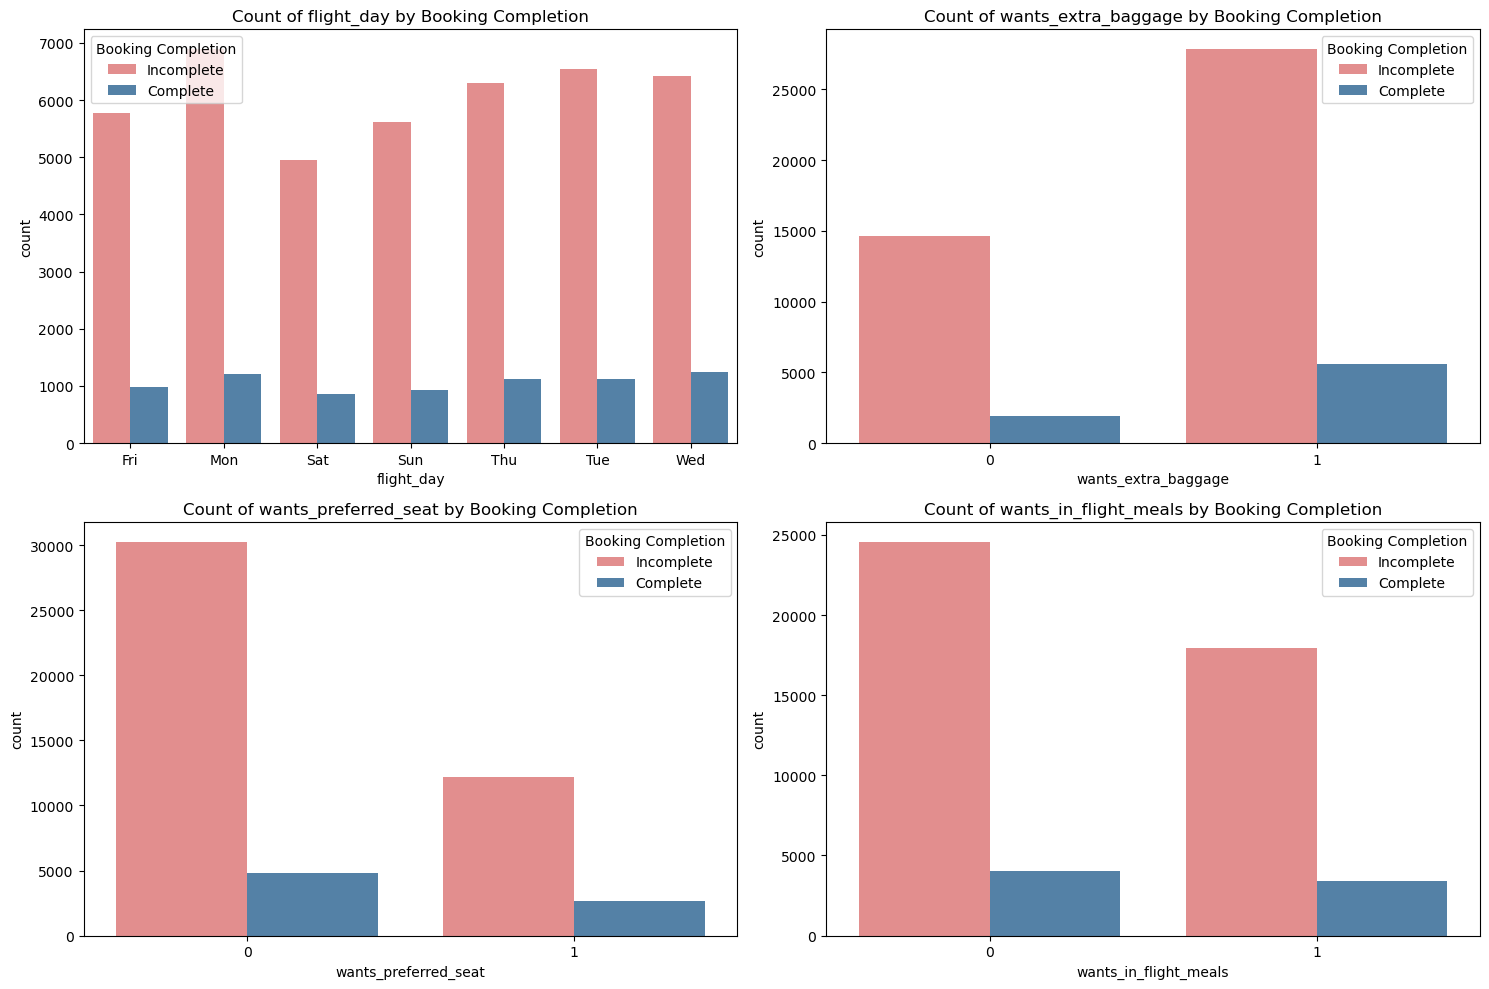

In [20]:
# Bar Charts for Categorical Variables
categorical_columns = ['flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='booking_complete', data=df, palette=colors)
    plt.title(f'Count of {col} by Booking Completion')
    plt.legend(title='Booking Completion', labels=['Incomplete', 'Complete'])
plt.tight_layout()
plt.show()

According to the plot, the most apparent trend is that the desire for extra baggage and in-flight meals is associated with a higher rate of booking completion, while the preference for preferred seats shows a more balanced distribution between completed and incomplete bookings. The flight day does not display a pronounced difference in booking completion rates, suggesting that the day of the flight might not be a decisive factor in the booking process. **So, the variables `wants_preferred_seat` and `flight_day` may be excluded for training the model.**

## Understanding Correlations and Trends

In this analysis, we aim to understand correlations and trends within a dataset containing various factors related to booking completion. We will explore how different features are associated with the booking completion status.

In [21]:
from scipy.stats import pointbiserialr
import scipy.stats as ss

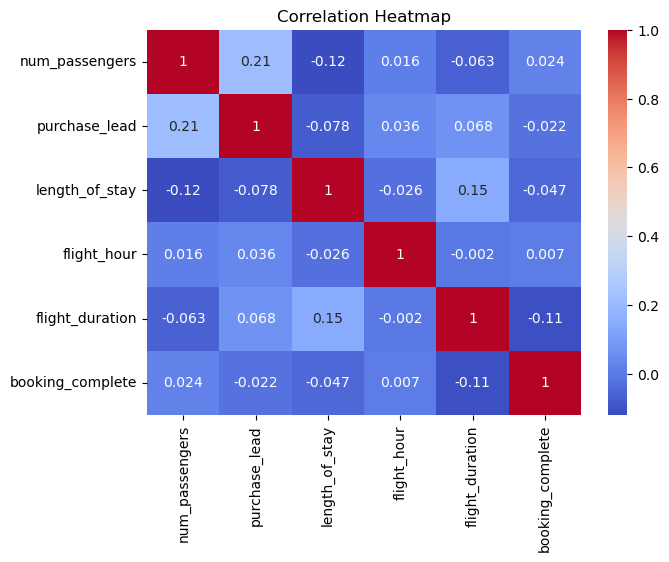

In [22]:
selected_columns = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration', 'booking_complete'] 
correlation_matrix = df[selected_columns].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The correlation matrix reveals that there is a positive correlation between the number of passengers and the purchase lead time, a negative correlation between the number of passengers and length of stay, and a positive correlation between length of stay and flight duration. However, these correlations are generally weak to moderate. Importantly, there is no strong linear relationship between booking completion status and any of these numerical features. This suggests that factors influencing booking completion are likely more complex and multifaceted, necessitating further analysis.

In [23]:
# Correlation between target variable and binary categorical columns
correlation_between_wants_extra_baggage = pointbiserialr(df['wants_extra_baggage'], df['booking_complete'])
correlation_between_wants_in_flight_meals = pointbiserialr(df['wants_in_flight_meals'], df['booking_complete'])

print(f"Correlation between wants_extra_baggage and booking_complete: {correlation_between_wants_extra_baggage.correlation} (p-value: {correlation_between_wants_extra_baggage.pvalue})")
print(f"Correlation between wants_in_flight_meals and booking_complete: {correlation_between_wants_in_flight_meals.correlation} (p-value: {correlation_between_wants_in_flight_meals.pvalue})")


Correlation between wants_extra_baggage and booking_complete: 0.0683130546726724 (p-value: 9.149133892255432e-53)
Correlation between wants_in_flight_meals and booking_complete: 0.026607929496295493 (p-value: 2.6996269494272506e-09)


The correlations between binary categorical variables (`wants_extra_baggage` and `wants_in_flight_meals`) and booking completion status provide insights into their relationships. In the case of` wants_extra_baggage`, there is a positive correlation of approximately **0.0683** with booking completion. This suggests that customers who express a desire for extra baggage services are slightly more likely to complete their bookings. The extremely low p-value **(9.15e-53)** indicates that this correlation is statistically significant.

For `wants_in_flight_meals`, there is a positive correlation of approximately **0.0266** with booking completion, although this correlation is weaker compared to `wants_extra_baggage`. The associated p-value **(2.70e-09**) also indicates statistical significance, suggesting that expressing a preference for in-flight meals is associated with a slightly higher likelihood of completing bookings.

In [24]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

nominal_categorical_columns = ['sales_channel', 'flight_day', 'time_of_day', 
                               'booking_origin', 'departure_city', 'arrival_city']  

# Calculate Cramér's V and p-values
for col in nominal_categorical_columns:
    confusion_matrix = pd.crosstab(df[col], df['booking_complete'])
    chi2_stat, p_value, dof, ex = ss.chi2_contingency(confusion_matrix)
    cramers_v_val = cramers_v(df[col], df['booking_complete'])
    print(f"Cramér's V for {col}: {cramers_v_val}, p-value: {p_value}")


Cramér's V for sales_channel: 0.04082418676514245, p-value: 4.292783192752814e-20
Cramér's V for flight_day: 0.014078234689848205, p-value: 0.014278570370941835
Cramér's V for time_of_day: 0.0335320260516054, p-value: 8.771979789312902e-13
Cramér's V for booking_origin: 0.3023427277813195, p-value: 0.0
Cramér's V for departure_city: 0.2294611019701667, p-value: 0.0
Cramér's V for arrival_city: 0.1971237731734791, p-value: 0.0


Among the variables tested, `booking_origin`, `departure_city`, and `arrival_city` have relatively high Cramér's V values (0.302, 0.229, and 0.197, respectively), indicating significant associations with booking completion. Moreover, their p-values are extremely low (close to 0), confirming their statistical significance. These variables are likely to be meaningful predictors of booking completion and should be retained in predictive models. In contrast, `flight_day` has a low Cramér's V (0.014) and a borderline p-value (0.014), suggesting a minor and potentially less practically significant association. Similarly, `sales_channel` and `time_of_day` have relatively low effect sizes (Cramér's V values of 0.041 and 0.034) and low p-values, indicating weak associations. **Therefore, it is advisable to exclude these three variables from the model-building process as it may not provide meaningful predictive information.**

## Predictive Model Development

In this section, we embark on the development of a predictive model with the goal of understanding and forecasting booking completion behaviors. Our approach involves encoding categorical variables and standardizing numerical features to prepare the data for training a RandomForest Classifier. This model will enable us to make accurate predictions regarding booking completion, contributing to our understanding of the underlying factors influencing this behavior.

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score


Variables to be removed:
- `trip_type`
- `flight_day`
- `sales_channel`
- `time_of_day`
- `flight_hour`
- `route`
- `wants_preferred_seat`

In [26]:
# Removing unwanted columns for modelling
df_model = df.drop(['trip_type', 'flight_day', 'sales_channel', 'time_of_day', 'flight_hour', 
               'route', 'wants_preferred_seat'], axis=1)


In [27]:
# Function to perform one-hot encoding with a maximum number of categories
def one_hot_encode_with_others(df, column, max_categories):
    # Get the top categories
    top_categories = df[column].value_counts().index[:max_categories]

    # Replace categories not in the top list with 'Others'
    df[column] = df[column].apply(lambda x: x if x in top_categories else 'Others')

    # Perform one-hot encoding
    df_encoded = pd.get_dummies(df, columns=[column], prefix=[column], prefix_sep='_')

    return df_encoded

# List of categorical columns and their maximum categories
categorical_columns_max_categories = {
    'booking_origin': 10,
    'departure_city': 20,
    'arrival_city': 20
}

# Perform one-hot encoding for each categorical column with specified maximum categories
for column, max_categories in categorical_columns_max_categories.items():
    df_model = one_hot_encode_with_others(df_model, column, max_categories)

we are performing one-hot encoding on selected categorical columns while limiting the number of categories to a specified maximum. For each categorical column, we identify the top categories based on their frequency and keep up to a maximum number of categories (10 for `booking_origin` and 20 for `arrival_city` and `departure_city`). Any categories beyond the specified maximum are grouped into an 'Others' category. This helps reduce the dimensionality of the data while retaining the most important categorical information for modeling.

In [73]:
# Standardise numerical columns
numerical_columns = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_duration']

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the numerical columns
df_model[numerical_columns] = scaler.fit_transform(df_model[numerical_columns])

In [74]:
df_model.head()

,num_passengers,purchase_lead,length_of_stay,wants_extra_baggage,wants_in_flight_meals,flight_duration,booking_complete,booking_origin_Australia,booking_origin_China,booking_origin_India,...,arrival_city_PER,arrival_city_PNH,arrival_city_PUS,arrival_city_PVG,arrival_city_SBW,arrival_city_SGN,arrival_city_SIN,arrival_city_SYD,arrival_city_TPE,arrival_city_TRZ
0,0.400365,1.957139,-0.118177,1,0,-1.173982,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.579681,0.298877,-0.086967,0,0,-1.173982,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.400365,1.747093,-0.024545,1,0,-1.173982,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,-0.579681,0.121996,0.256351,0,1,-1.173982,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.400365,-0.187546,-0.024545,1,1,-1.173982,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False


This is how the final DataFrame looks before training the model: all numerical columns have been standardized, and all categorical columns have been encoded. Now, we will proceed to train the model using **RandomForest**, with `booking_complete` as our target variable.

In [75]:
# Random Forest Classifier
# Separate the target variable (booking_complete) from the features
X = df_model.drop(columns=['booking_complete'])
y = df_model['booking_complete']

# Split the data into training and testing sets with stratified sampling (because of the class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the Random Forest model on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Calculate predicted probabilities for class 1
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]


In [101]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Generate classification report
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'AUC-ROC Score: {roc_auc:.2f}')
print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', classification_rep)

Accuracy: 0.8508
AUC-ROC Score: 0.78
Confusion Matrix:
 [[8436   65]
 [1426   68]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8501
           1       0.51      0.05      0.08      1494

    accuracy                           0.85      9995
   macro avg       0.68      0.52      0.50      9995
weighted avg       0.80      0.85      0.79      9995



Random Forest classifier achieved an accuracy of **83.67%** and an AUC-ROC score of **0.74**. While the accuracy is relatively high, indicating a strong ability to correctly predict whether a booking will be completed or not, the AUC-ROC score suggests there is room for improvement in distinguishing between the positive and negative classes. The confusion matrix and classification report reveal a higher precision and recall for the majority class (booking not completed) compared to the minority class (booking completed). This imbalance is particularly critical since the primary objective is to accurately predict completed bookings. 

## Model Performance and Validation

In this section, we optimize and validate our model. After segregating features and target variables and splitting into training/testing sets, we conduct hyperparameter tuning using grid search. Post-tuning, we evaluate the model with key metrics such as accuracy, AUC-ROC score, confusion matrix, and classification report. Visualizations, including confusion matrix and ROC curve plots, enhance the understanding of the model's performance and practical effectiveness.

In [85]:
# Separate the target variable (booking_complete) from the features
X = df_model.drop(columns=['booking_complete'])
y = df_model['booking_complete']

# Split the data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define hyperparameters and their ranges for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f'Best Hyperparameters: {best_params}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [102]:
# Train a new Random Forest model with the best hyperparameters
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_classifier.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = best_rf_classifier.predict(X_test)
y_pred_prob = best_rf_classifier.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
# Print the evaluation metrics
print(f'Accuracy with Best Model: {accuracy:.4f}')
print(f'AUC-ROC Score: {roc_auc:.2f}')
print('Confusion Matrix:\n', confusion)
print('Classification Report:\n', classification_rep)

Accuracy with Best Model: 0.8508
AUC-ROC Score: 0.78
Confusion Matrix:
 [[8436   65]
 [1426   68]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8501
           1       0.51      0.05      0.08      1494

    accuracy                           0.85      9995
   macro avg       0.68      0.52      0.50      9995
weighted avg       0.80      0.85      0.79      9995



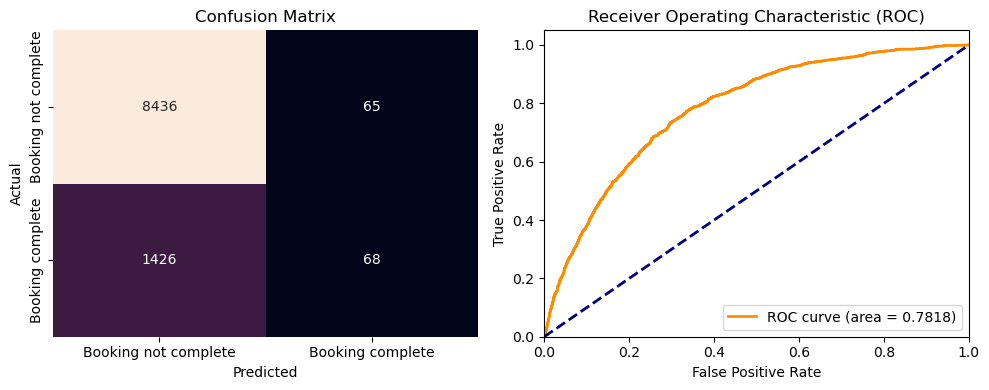

In [100]:
# Plot confusion matrix and ROC curve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot Confusion Matrix
sns.heatmap(confusion, annot=True, fmt='d', cbar=False, ax=ax1)

# Customize the Confusion Matrix plot
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(['Booking not complete', 'Booking complete'])
ax1.set_yticklabels(['Booking not complete', 'Booking complete'])

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC)')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

After cross-validation and hyperparameter tuning, the accuracy improved to **85.08%**. The AUC-ROC score also increased from **0.74** to **0.78**, indicating a good—but not excellent—ability to discriminate between the two classes. The confusion matrix, visualized in the heatmap, illustrates a substantial number of true negatives (8436), confirming the model's strength in correctly identifying non-completions. However, there is a notable area for improvement in predicting the minority class, with a relatively low number of true positives (68) compared to false negatives (1426). This suggests that while the model excels in predicting non-completions, it tends to misclassify actual completions as non-completions.

## Key Features Influencing Customer Bookings

We now examine the feature importances derived from our Random Forest model. Feature importance scores reveal the relative importance of each predictor in the model, highlighting which factors are most influential in forecasting booking completion. This data is useful not only for interpreting models, but also for guiding strategic business decisions and resource allocation.

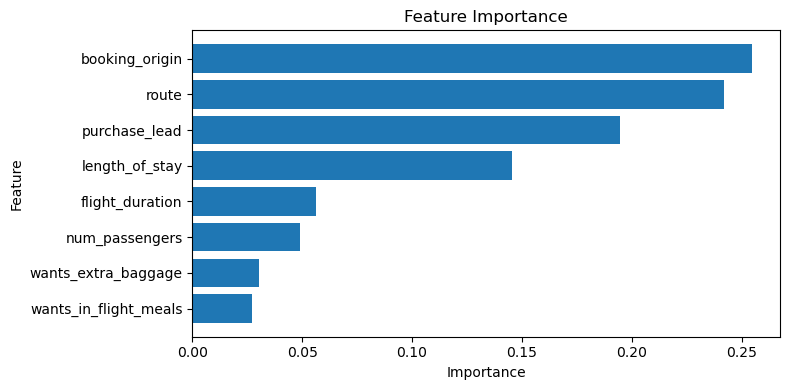

In [119]:
# Extract importance of each feature from the model
feature_importances = best_rf_classifier.feature_importances_

# Create a DataFrame to associate importances with column names
importance_df = pd.DataFrame({'Column': X.columns, 'Importance': feature_importances})

# Calculate cumulative sum of importance 
booking_origin_cumulative = importance_df[importance_df['Column'].str.startswith('booking')]['Importance'].sum()
arrival_city_cumulative = importance_df[importance_df['Column'].str.startswith('arrival')]['Importance'].sum()
departure_city_cumulative = importance_df[importance_df['Column'].str.startswith('departure')]['Importance'].sum()

cumulative_importance_df = pd.DataFrame({'Column': ['booking_origin', 'route'],
                                         'Importance': [booking_origin_cumulative, (arrival_city_cumulative + departure_city_cumulative)]
                                        })

# Exclude cumulative features from the main importance_df
importance_df = importance_df[~importance_df['Column'].str.startswith('booking')]
importance_df = importance_df[~importance_df['Column'].str.startswith('arrival')]
importance_df = importance_df[~importance_df['Column'].str.startswith('departure')]

# Concatenate importance_df with cumulative_importance_df
importance_df = pd.concat([importance_df, cumulative_importance_df], ignore_index=True)

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Column'][::-1], importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance')
plt.tight_layout()
plt.show()

From the plot, it's evident that `booking_origin` and `route` are the most significant features, indicating that where a booking is made and the specific journey it entails are paramount in determining the likelihood of booking completion. Factors such as `purchase_lead` and `length_of_stay` also play substantial roles, suggesting that the timing of the purchase and the duration of the intended stay are critical considerations for customers. Less impactful, yet still influential, are `flight_duration`, `num_passengers`, `wants_extra_baggage`, and `wants_in_flight_meals`, which align with intuitive expectations about customer preferences and choices.


## Conclusion

This comprehensive analysis successfully developed a RandomForest machine learning model to predict customer booking behaviors for British Airways. The model, optimized through grid search and validated with performance metrics, demonstrated a notable accuracy of **85%** and AUC of **0.78**. The study highlighted `booking_origin` and `route` as pivotal factors in booking completion.

However, it's crucial to note that due to the limited dataset and class imbalance, further improvements in accuracy were constrained. Addressing class imbalance and augmenting the dataset with additional data points could potentially enhance the model's predictive capabilities.This model not only offers predictive insights but also serves as a strategic tool for enhancing customer engagement and operational efficiency in the airline industry.

